In [1]:
# For this notebook, I will walk through this article linked below: 
# https://www.kdnuggets.com/2018/03/text-data-preprocessing-walkthrough-python.html

In [2]:
import pandas as pd # Uploading pandas dataframe
import re, string, unicodedata # Removing punctuation, converting rows into string
import nltk # Natural language processing library
import contractions # Parses contractions
import inflect # Generating plurals, singulars, numbers to words
from bs4 import BeautifulSoup # online scraper
from nltk import word_tokenize, sent_tokenize #Tokenization of words, sentences
from nltk.stem import LancasterStemmer, WordNetLemmatizer #Lemmatization of words
from nltk import punkt # Needed to tokenize words
from nltk.corpus import stopwords # Needed for normalization
from nltk.corpus import wordnet # Find meaning of words, synonyms, antonyms.
from sklearn.feature_extraction.text import CountVectorizer #Gets counts of words for sparse matrix
from scipy import sparse # Saves sparse matrix for later

In [3]:
# Read in kickstarter data as csv

kickstarter = pd.read_csv(r'../kickstarter.csv', index_col = 0)

In [4]:
# Operating on the text columns, name, and blurb.

text = kickstarter['name'] + ' ' + kickstarter['blurb']

In [6]:
# Formatting everything as a string

to_string = text.astype(str)

In [7]:
# Replacing contractions.

def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)


In [8]:
# Replacing contractions

without_contractions = to_string.map(lambda x: replace_contractions(x))

In [9]:
# Applying word tokenization

tokens = without_contractions.map(lambda x: nltk.word_tokenize(x))

In [10]:
# Normalization

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# Taking out replacing numbers because not important for analysis.
def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if not any(ch.isdigit() for ch in word):
            new_words.append(word)
    return new_words

# Moving stopwords_list out of function leads to massive performance improvement.
stopwords_list = stopwords.words('english')
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords_list:
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

In [11]:
# Normalizing words using the functions above.

normalized = tokens.map(lambda x: normalize(x))

In [12]:
# Lemmatizing verbs: changing verbs to infinite form 

lemmatized = normalized.map(lambda x: lemmatize_verbs(x))

In [13]:
# Gets rid of numbers. Have to do this because vectorizer cannot lower case numbers.

no_numbers = lemmatized.map(lambda x: replace_numbers(x))

In [22]:
cleaned = no_numbers.astype(str)
cleaned.head()

0    ['remix', 'explore', 'paint', 'place', 'digita...
1    ['photo', 'grant', 'hazel', 'eat', 'cake', 'ba...
2    ['minecraft', 'digital', 'artanimations', 'nee...
3    ['sacramento', 'nature', 'photograph', 'series...
4    ['north', 'africa', 'art', 'project', 'dream',...
dtype: object

In [28]:
# Gets rid of rare words

vectorizer = CountVectorizer(min_df=.001) 
X = vectorizer.fit_transform(cleaned)
y = kickstarter['binary_state']

In [24]:
# Set up a list of alphabetized dictionary keys to use as list features.
list(vectorizer.get_feature_names())

['abandon',
 'ability',
 'able',
 'abstract',
 'abuse',
 'academy',
 'accept',
 'access',
 'accessible',
 'accessories',
 'accessory',
 'acclaim',
 'accompany',
 'account',
 'achieve',
 'acoustic',
 'across',
 'acrylic',
 'act',
 'action',
 'active',
 'activities',
 'activity',
 'actors',
 'actually',
 'adapt',
 'adaptation',
 'add',
 'addict',
 'addiction',
 'adorable',
 'adult',
 'adults',
 'advance',
 'adventure',
 'affect',
 'affordable',
 'africa',
 'african',
 'age',
 'ago',
 'ai',
 'aid',
 'aim',
 'air',
 'aka',
 'al',
 'album',
 'albums',
 'alert',
 'alex',
 'alien',
 'alive',
 'allinone',
 'allow',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'alternative',
 'aluminum',
 'always',
 'amaze',
 'ambitious',
 'america',
 'american',
 'among',
 'ancient',
 'android',
 'angel',
 'angeles',
 'angels',
 'animal',
 'animals',
 'animate',
 'animation',
 'anime',
 'anniversary',
 'annual',
 'another',
 'answer',
 'anthology',
 'anyone',
 'anything',
 'anytime',
 'anywhere',
 'apa

In [25]:
X_words = pd.DataFrame(X.toarray(), columns=list(vectorizer.get_feature_names()))
X_words.to_csv('kickstarter_vocab.csv')

In [26]:
# Saves matrix for machine learning in other notebook. Comment is to read in matrix.

sparse.save_npz("kickstarter.npz", X)
# your_matrix_back = sparse.load_npz("kickstarter.npz")

In [37]:
# Binarizing labels into yes/no for successful/failed

from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(kickstarter.binary_state).ravel()


In [32]:
# Minmax scaler for Naive Bayes

def maxabsscaler(X):
    ''' Performs minmaxscaling for Naive Bayes. Returns transformed matrix. '''
    from sklearn.preprocessing import MaxAbsScaler
    scaler = MaxAbsScaler()
    X = scaler.fit_transform(X)
    return (X)

In [ ]:
# Function to score different machine learning models.

def score_model(clf, X_input_data, y_true):
    '''
    Scores a machine learning model, provides summary statistics, plots ROC curve.
   
    Inputs: classifier, X_input_data (X_train or X_test), y_true (y_train or y_test)
    ''' 
    
    # Scoring models. Test model. Change to allow prediction for X_train
    y_pred = clf.predict(X_input_data)

    # Fit an accuracy score
    from sklearn.metrics import accuracy_score
    print('\n Accuracy Score: \n \n', "{:.2%}".format(accuracy_score(y_true, y_pred, normalize=True)))

    # Create confusion matrix
    from sklearn.metrics import confusion_matrix
    print('\n Confusion Matrix: \n \n', confusion_matrix(y_true, y_pred))

    # Print classification report
    from sklearn.metrics import classification_report
    print('\n Classification Report: \n \n', classification_report(y_true, y_pred))

    # Generate ROC plot
    from sklearn.metrics import roc_curve
    import matplotlib.pyplot as plt

    # Compute predicted probabilities: y_pred_prob. Try except for SGD: hinge loss model.
    try:
        y_pred_prob = clf.predict_proba(X_input_data)[:,1]
        
        # Generate ROC curve values: fpr, tpr, thresholds
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

        # Plot ROC curve
        f, ax = plt.subplots(figsize=(8, 8))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.show()
    
    except AttributeError:
        print('Probability estimates not available \n')

In [35]:
# Splitting data into training and testing. In function to call before naive bayes.

def train_test_split(X, y):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    return (X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_split(X, y)


 Accuracy Score: 
 
 66.50%

 Confusion Matrix: 
 
 [[149293  23178]
 [ 73553  42704]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.67      0.87      0.76    172471
           1       0.65      0.37      0.47    116257

    accuracy                           0.66    288728
   macro avg       0.66      0.62      0.61    288728
weighted avg       0.66      0.66      0.64    288728



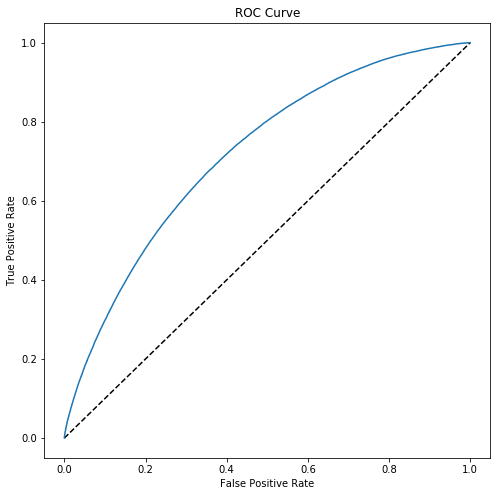

In [39]:
from sklearn.naive_bayes import MultinomialNB
X_minmax = maxabsscaler(X)
X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(X_minmax, y)
nb = MultinomialNB()
fitted = nb.fit(X_train_mm, y_train_mm.ravel())
score_model(fitted, X_train_mm, y_train_mm)

In [46]:
# Bonus: Get the most, least likely words in blurb / topic for approval
import numpy as np
x = np.eye(X_words.shape[1])
coefs = nb.predict_proba(x)[:, 1]
feature_list = list(X_words)
df = pd.DataFrame(coefs, feature_list, columns=['Probability | Word'])
df['Probability'] = df['Probability'].apply(lambda x: "%.2f" % x)
top_words = df.sort_values('Probability', ascending=False).head(10)
bottom_words = df.sort_values('Probability').head(10)
print(top_words, '\n')
print(bottom_words)

           Probability
miniatures        0.87
printable         0.86
cthulhu           0.86
pathfinder        0.82
titanium          0.81
edc               0.80
terrain           0.79
dice              0.76
miniature         0.76
stretch           0.76 

            Probability
cancel             0.02
application        0.09
app                0.09
cater              0.11
network            0.12
website            0.12
shooter            0.13
users              0.13
platform           0.14
youtube            0.14
